## Notebook for evaluation of a trained AutoEncoder Model
- This notebook is step 1 of 3 in setting up a model pipeline for generating particle decay event images
- The notebook is broken up into the following components:
    - Loss evaluation and plotting
        - The loss for the entire training cycle is plotted
        - The mean and stddev for the loss values for model checkpoints between 600 to 1000.
            - We compute the average loss value over 10k test samples and 10k training samples
    - An appropriately generalizable Decoder is chosen based on the smalled difference in MSE value from the previous evaluation step
    - Sets of sample images are generated for that checkpoint using test data in order to assess image reconstruction quality
    - A set of code vector targets is generated using that model checkpoint

## Import Libraries

In [57]:
import os
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline

### Import Files from full path on Meitner Machine

In [2]:
import sys
sys.path.insert(1, '/home/kseuro/Kai/deeplearnphysics/pytorch/particle_generator/')

# Meitner Machine
import ae
import conv_ae
import utils
from dataloader import LArCV_loader

#### Set the GPU to be used for model evaluation
- On Meitner, GPU 1 is the best option

In [3]:
device = torch.device(0)

#### Set the root path of the AutoEncoder Experiments Folder

In [4]:
exp_root = "/media/hdd1/kai/particle_generator/experiments/"

#### Select the model class and append to the experiment root

In [5]:
model_class = {'mlp': 'mlp_ae/', 'conv':'conv_ae/'}

In [6]:
model_folder = "larcv_ae/" + model_class['conv']

In [7]:
exp_root += model_folder

### Find all the experiments in the exp_root folder

In [8]:
exp_paths = []
for path in os.listdir(exp_root):
    exp_paths.append(os.path.join(exp_root, path))

In [9]:
print("-"*60)
for i in range(len(exp_paths)):
    exp_name = exp_paths[i].split('/')[-1]
    print("\n{}:".format(str(i)), exp_name, '\n')
    print("-"*60)

------------------------------------------------------------

0: conv_ae_256_16384 

------------------------------------------------------------

1: conv_ae_128_320 

------------------------------------------------------------

2: conv_ae_256_6528 

------------------------------------------------------------

3: conv_ae_64_384 

------------------------------------------------------------

4: conv_ae_128_1280 

------------------------------------------------------------

5: conv_ae_64_192 

------------------------------------------------------------

6: conv_ae_265_1632 

------------------------------------------------------------


### Choose the experiment for evaluation

In [10]:
exp_dir = exp_paths[3]

In [11]:
# Create the full path to the experiment
exp_path = os.path.join(exp_root, exp_dir) + "/"
print("Experiment path set as: \n{}".format(exp_path))

Experiment path set as: 
/media/hdd1/kai/particle_generator/experiments/larcv_ae/conv_ae/conv_ae_64_384/


In [12]:
# Set path from where to load the model weights
weights_dir = "weights/"

### Load the model configuration information from the config.csv

In [13]:
# Load the config csv as a dict
config_csv = exp_path + "config.csv"
config_df = pd.read_csv(config_csv, delimiter = ",")

In [14]:
# Get the model architecture from config df
num_epochs = int(config_df[config_df['Unnamed: 0'].str.contains("epochs")==True]['0'].values.item())
n_layers = int(config_df[config_df['Unnamed: 0'].str.contains("n_layers")==True]['0'].values.item())
l_dim    = int(config_df[config_df['Unnamed: 0'].str.contains("l_dim")==True]['0'].values.item())
depth    = int(config_df[config_df['Unnamed: 0'].str.contains("depth")==True]['0'].values.item())
im_size  = int(config_df[config_df['Unnamed: 0'].str.contains("dataset")==True]['0'].values.item())**2
im_dim   = int(np.sqrt(im_size))

## Setup PyTorch DataLoader

### Set the paths to the test data and reference training set

#### Test Data

In [15]:
test_data = "/media/hdd1/kai/particle_generator/larcv_data/test/larcv_png_{}/".format(im_dim)
num_test_ex = sum( [len(examples) for _, _, examples in os.walk(test_data)] )
print("{} test data will be loaded from: \n{}".format(num_test_ex, test_data))

10000 test data will be loaded from: 
/media/hdd1/kai/particle_generator/larcv_data/test/larcv_png_64/


#### Reference Training Data

In [16]:
train_data = "/media/hdd1/kai/particle_generator/larcv_data/train/train_reference/larcv_png_{}/".format(im_dim)
num_train_ex = sum( [len(examples) for _, _, examples in os.walk(train_data)] )
print("{} reference training data will be loaded from: \n{}".format(num_train_ex, train_data))

10000 reference training data will be loaded from: 
/media/hdd1/kai/particle_generator/larcv_data/train/train_reference/larcv_png_64/


#### Setup two instances of a dataloader object

In [17]:
loader_kwargs = {'num_workers' : 2, 'batch_size': 1, 'shuffle': True}

In [18]:
transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5],[0.5])])

In [19]:
test_dataset = LArCV_loader(root = test_data,  transforms = transforms)

Image conversion flag is: L
Images will be loaded from subfolder of: /media/hdd1/kai/particle_generator/larcv_data/test/larcv_png_64/


In [20]:
test_loader = DataLoader(test_dataset, **loader_kwargs)

In [21]:
train_dataset   = LArCV_loader(root = train_data, transforms = transforms)

Image conversion flag is: L
Images will be loaded from subfolder of: /media/hdd1/kai/particle_generator/larcv_data/train/train_reference/larcv_png_64/


In [22]:
train_loader = DataLoader(train_dataset, **loader_kwargs)

### Compute the layer dimensions for the AutoEncoder
- TODO: Need to add function that deals with an AutoEncoder Model trained on MNIST

In [23]:
# Set up AE layer sizes
if 'mlp' in exp_path:    
    base = [256] 

    # Compute encoder sizes
    sizes = lambda: [ (yield 2**i) for i in range(n_layers) ]
    enc_sizes = base * n_layers
    enc_sizes = [a*b for a,b in zip(enc_sizes, [*sizes()])][::-1]

    # Update kwarg dicts
    # Decoder is the reverse of the encoder
    ae_kwargs = {'enc_sizes' : enc_sizes, 'l_dim' : l_dim, 'im_size' : im_size, 'dec_sizes' : enc_sizes[::-1]}
else:
    # Compute the depth of the feature maps, based on the number of
    # specified layers. If depth is not divisibe by 4, warn
    depth   = [depth] * n_layers
    divisor = lambda: [ (yield 2**i) for i in range(n_layers) ]
    depth   = [a//b for a,b in zip(depth, [*divisor()])][::-1]
        
    # Update kwarg dicts
    # Decoder is the reverse of the encoder
    ae_kwargs = {'enc_depth':[1] + depth, 'dec_depth':depth[1:len(depth)][::-1] + [1],'l_dim':l_dim}

In [24]:
print("Model l_dim: {}".format(l_dim))
print("Encoder depth: {}".format(ae_kwargs['enc_depth']))
print("Decoder depth: {}".format(ae_kwargs['dec_depth']))

Model l_dim: 6
Encoder depth: [1, 8, 16, 32]
Decoder depth: [32, 16, 1]


### Setup Model loss function

In [25]:
loss_fn = nn.MSELoss().to(device)

### Set up tracking of MSE evaluation results

In [26]:
test_means = []; test_stds = []; train_means = []; train_stds = []

## Load Model from Checkpoint

### Get the list of checkpoint files

In [27]:
checkpoint_path  = exp_path + weights_dir
checkpoint_names = []
for file in os.listdir(checkpoint_path):
    checkpoint_names.append(os.path.join(checkpoint_path, file))

In [28]:
# We wish to save a list of labels for ease of plot labelling later
checkpoint_name_labels = []

In [29]:
print("-"*60)
for i in range(len(checkpoint_names)):
    name = checkpoint_names[i].split('/')[-1]
    checkpoint_name_labels.append(name)
    print("\n{}:".format(str(i)), name, '\n')
    print("-"*60)

------------------------------------------------------------

0: best_conv_ae_ep_650.tar 

------------------------------------------------------------

1: best_conv_ae_ep_600.tar 

------------------------------------------------------------

2: best_conv_ae_ep_999.tar 

------------------------------------------------------------

3: best_conv_ae_ep_700.tar 

------------------------------------------------------------

4: best_conv_ae_ep_850.tar 

------------------------------------------------------------

5: best_conv_ae_ep_900.tar 

------------------------------------------------------------

6: best_conv_ae_ep_950.tar 

------------------------------------------------------------

7: best_conv_ae_ep_750.tar 

------------------------------------------------------------

8: best_conv_ae_ep_800.tar 

------------------------------------------------------------


### Select the checkpoint you wish to evaluate

In [30]:
index = 2
current_checkpoint = checkpoint_names[index]
current_checkpoint_label = checkpoint_name_labels[index]

### Load the checkpoint file using PyTorch

In [31]:
# Load the model checkpoint
# Keys: ['state_dict', 'epoch', 'optimizer']
checkpoint = torch.load(current_checkpoint)

### Set up the model on the GPU

In [32]:
# Set up model on GPU
if 'mlp' in exp_path:
    model = ae.AutoEncoder(**ae_kwargs).to(device)
else:
    model = conv_ae.ConvAutoEncoder(**ae_kwargs).to(device)

### Load the model's state dictionary

In [33]:
model.load_state_dict(checkpoint['state_dict'], strict=False)

<All keys matched successfully>

### Put model in evaluation mode

In [34]:
model.eval()

ConvAutoEncoder(
  (encoder): ConvEncoder(
    (conv_blocks): Sequential(
      (0): Sequential(
        (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2)
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (1): Sequential(
        (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2)
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (2): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2)
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (last): Conv2d(32, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (decoder): ConvDecoder(
    (deconv_blocks): Sequential(
      (0): Sequential(
        (0): ConvTranspose2d(6, 32, k

### If evaluating convolutional model, get the size of the code tensor using a random torch tensor

In [35]:
if 'conv' in exp_path:
    x = torch.randn(1, 1, im_dim, im_dim).to(device)
    x = model.encoder(x)
    code = (x.shape[1], x.shape[2], x.shape[3])
    print("Code tensor volume is: [{} x {} x {}] = {}".format(code[0], code[1], code[2], code[0]*code[1]*code[2]))

Code tensor volume is: [6 x 8 x 8] = 384


## Get Model Loss Curves

### Full loss curve for entire training cycle

In [36]:
losses_csv = exp_path + "losses.csv"
losses_df = pd.read_csv(losses_csv, delimiter = ",")
losses = np.asarray(losses_df['ae_loss'])

In [37]:
# Compute average loss per epoch based based on loss array len
step = int(len(losses) / num_epochs)
new_losses = []
for i in range(0, len(losses), step):
    new_losses.append( sum(losses[i:i+step]) / step )
new_losses = np.asarray(new_losses)

### Compute the label for the checkpoint being evaluated

In [38]:
checkpoint_label = current_checkpoint_label.split('.')[0].split('_')[-1]
test_label = 'test_ep_{}'.format(checkpoint_label)
train_label = 'train_ep_{}'.format(checkpoint_label)

In [39]:
print(checkpoint_label, test_label, train_label)

999 test_ep_999 train_ep_999


### Loss values for test dataset

In [40]:
test_losses = []; test_ims = []; samples = []; limit = 16

In [41]:
for idx, image in enumerate(test_loader):
    
    # Flatten image into a vector -- if mlp
    if 'mlp' in exp_path:
        image = image.view(loader_kwargs['batch_size'], -1).to(device)
    else:
        image = image.to(device)
    
    # Forward pass
    output = model(image)
    
    # Save list of samples for plotting later
    if idx < limit:
        # Concatenate the two images along the channel dimension and append to list
        # For later plotting with MatPlotLib below this cell
        test_ims.append(image.view(-1, im_dim, im_dim).detach().cpu().numpy())
        samples.append(output.view(-1, im_dim, im_dim).detach().cpu().numpy())

    # Get the loss value for the batch
    loss = loss_fn(output, image)
    
    # Append loss value
    test_losses.append(float(loss.item()))

#### Get the mean and stddev for the checkpoint file

In [42]:
test_mean = np.mean(test_losses)
test_std  = np.std(test_losses) 

In [43]:
test_means.append(test_mean)
test_stds.append(test_std)

### Loss values for reference-train dataset

In [44]:
ref_train_losses = []

In [45]:
for idx, image in enumerate(train_loader):    

    # Flatten image into a vector
    if 'mlp' in exp_path:
        image = image.view(loader_kwargs['batch_size'], -1).to(device)
    else:
        image = image.to(device)
    
    # Forward pass
    output = model(image)
    
    # Get the loss value for the batch
    loss = loss_fn(output, image)
    
    # Append loss value
    ref_train_losses.append(float(loss.item()))

In [46]:
train_mean = np.mean(ref_train_losses)
train_std  = np.std(ref_train_losses) 

In [47]:
train_means.append(train_mean)
train_stds.append(train_std)

### Free the GPU memory

In [ ]:
del model

### Plot a set of sample images

In [ ]:
%matplotlib inline
# Setup figure
fig, axes = plt.subplots(nrows = 2, ncols = limit//2, sharex=True, sharey=True, figsize=(25,6))

# Set title
if 'mlp' in exp_path:
    m_label = 'AE_test_set'
else:
    m_label = 'Conv_AE_test_set'

# Generate plot
for images, row in zip([test_ims, samples], axes):
    for img, ax in zip(images, row):
        img = np.reshape(img, (im_dim, im_dim))
        ax.imshow(img, cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.tick_params(axis='x', colors='#443941')
        ax.tick_params(axis='y', colors='#443941')

fig.tight_layout()

# Save figure
save_file = "{}_{}_{}.png".format(m_label, im_dim, code[0]*code[1]*code[2])
plt.savefig(save_file, dpi=300)

### Plot the Full Results

In [ ]:
# Compute the plot title
if 'mlp' in exp_path:
    title = "MLP AutoEncoder Training Loss" 
else:
    title = "Convolutional AutoEncoder Training Loss"

In [ ]:
# Compute the experiment label
if 'mlp' in exp_path:
    label = "{}x{} Dataset | {} Dimensional Code Vector".format(im_dim, im_dim, l_dim)
else:
    label = "{}x{} Dataset | {}x{}x{} Dimensional Code Volume".format(im_dim, im_dim, code[0], code[1], code[2])

In [ ]:
# Compute the file name for saving
if 'mlp' in exp_path:
    save_file = "training_loss_MLP_AE_{}_dataset_{}_l-dim.png".format(im_dim, l_dim)
else:
    save_file = "training_loss_Conv_AE_{}_dataset_{}-{}-{}_code-volume.png".format(im_dim, code[0], code[1], code[2])

In [ ]:
%matplotlib inline
checkpoints = [i for i in range(600, 1050, 50)]
colors = ['black', 'green', 'magenta', 'gray'] 

# Train Loss Label
l0 = Line2D([0], [0], color='blue', lw=2, label='Train Loss')

# Train Legend Labels
l1 = Line2D([0], [0], marker='o', color=colors[0], label='Train Mean',   markerfacecolor= colors[0], markersize=10)
l2 = Line2D([0], [0], color=colors[1], lw=2, label='Train StdDev')

# Test Legend Labels
l3 = Line2D([0], [0], marker='x', color=colors[2], label='Test Mean',    markerfacecolor= colors[2], markersize=10)
l4 = Line2D([0], [0], color=colors[3], lw=2, label='Test StdDev')

# Create custom legend list
legend = [l0, l1, l2, l3, l4]

# Plot the losses against the number of epochs
fig, axes = plt.subplots(1,1)
fig.suptitle(title)

axes.set_title(label, fontsize="small")
axes.set_xlabel("Model Checkpoint Number")
axes.set_ylabel("Loss Value")

axes.plot(np.arange(0, num_epochs), new_losses, color = 'k')

# Plot data
for i in range(len(train_means)):
    # Reference Training Set
    label = 'train_ep_{}'.format(checkpoints[i])
    axes.errorbar(checkpoints[i], train_means[i], yerr=train_stds[i], color=colors[0],
                  ecolor = colors[1], label=label, fmt='o')
    
    # Test Set
    label = 'test_ep_{}'.format(checkpoints[i])
    axes.errorbar(checkpoints[i], test_means[i],  yerr=test_stds[i], color=colors[2],
                  ecolor = colors[3], label=label, fmt='x')

axes.legend(handles = legend)

# Generate and save image
plt.savefig(save_file, dpi=300)

### Plot the individual checkpoint results

In [ ]:
# Compute the plot title
if 'mlp' in exp_path:
    title = "MLP AutoEncoder Checkpoint Evaluation" 
else:
    title = "Convolutional AutoEncoder Checkpoint Evaluation"

In [ ]:
# Compute the experiment label
if 'mlp' in exp_path:
    label = "{}x{} Dataset | {} Dimensional Code Vector".format(im_dim, im_dim, l_dim)
else:
    label = "{}x{} Dataset | {}x{}x{} Dimensional Code Volume".format(im_dim, im_dim, code[0], code[1], code[2])

In [ ]:
# Compute the file name for saving
if 'mlp' in exp_path:
    save_file = "checkpoint_eval_MLP_AE_{}_dataset_{}_l-dim.png".format(im_dim, l_dim)
else:
    save_file = "checkpoint_eval_Conv_AE_{}_dataset_{}-{}-{}_code-volume.png".format(im_dim, code[0], code[1], code[2])

In [ ]:
%matplotlib inline
checkpoints = [i for i in range(600, 1050, 50)]
colors = ['black', 'green', 'magenta', 'gray'] 

l0 = Line2D([0], [0], color='blue', lw=2, label='Train Loss')

# Train Legend Labels
l1 = Line2D([0], [0], marker='o', color=colors[0], label='Train Mean',   markerfacecolor= colors[0], markersize=10)
l2 = Line2D([0], [0], color=colors[1], lw=2, label='Train StdDev')

# Test Legend Labels
l3 = Line2D([0], [0], marker='x', color=colors[2], label='Test Mean',    markerfacecolor= colors[2], markersize=10)
l4 = Line2D([0], [0], color=colors[3], lw=2, label='Test StdDev')

# Create custom legend list
legend = [l0, l1, l2, l3, l4]

# Plot the losses against the number of epochs
fig, axes = plt.subplots(1,1)
fig.suptitle(title)

axes.set_title(label, fontsize="small")
axes.set_xlabel("Model Checkpoint Number")
axes.set_ylabel("Loss Value")

axes.plot(np.arange(600, 1000), new_losses[600:])

# Plot data
for i in range(len(train_means)):
    # Reference Training Set
    label = 'train_ep_{}'.format(checkpoints[i])
    axes.errorbar(checkpoints[i], train_means[i], yerr=train_stds[i], color=colors[0],
                  ecolor = colors[1], label=label, fmt='o')
    
    # Test Set
    label = 'test_ep_{}'.format(checkpoints[i])
    axes.errorbar(checkpoints[i], test_means[i],  yerr=test_stds[i], color=colors[2],
                  ecolor = colors[3], label=label, fmt='x')


axes.legend(handles = legend)
# Generate and save image
plt.savefig(save_file, dpi=300)

## Plot Histograms of peak loss regions

In [48]:
def get_max_count(n):
    max_counts = 0; idx = 0
    for i in range(len(n)):
        if n[i] > max_counts:
            max_counts = n[i]
            idx = i
    return idx

In [49]:
def loss_hist(losses, checkpoint_label, test=False):
    n, bins, patches = plt.hist(losses, bins=5000)
    if test:
        plt.suptitle("Test Set Loss Value Distribution")
    else:
        plt.suptitle("Train Set Loss Value Distribution")
        
    plt.title("min: {} | max: {}".format(round(min(losses), 4), round(max(losses), 3)))
    plt.xlabel('Loss Value')
    plt.ylabel('Counts')

    max_count = get_max_count(n)
    plt.axvline(x = bins[-1], color = 'r', label = "max")
    plt.axvline(x = bins[-2], color = 'r', label = "max")
    plt.axvline(x = bins[-3], color = 'r', label = "max")

    plt.axvspan( bins[max_count - 50], bins[max_count + 50], alpha = 0.5, color='r')
    
    if test:
        plt.savefig('test_loss_dist_checkpoint_{}.png'.format(checkpoint_label), dpi=300)
    else:
        plt.savefig('train_loss_dist_checkpoint_{}.png'.format(checkpoint_label), dpi=300)

    return bins[max_count - 50], bins[max_count + 50], [bins[-3], bins[-2], bins[-1]]

## Plot the loss value distribution
- loss_hist returns two numbers corresponding to the bottom and top of the range of loss values to investigate

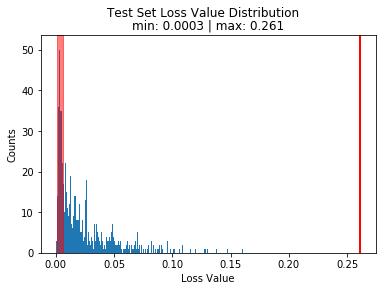

In [58]:
test_min, test_max, test_top = loss_hist(test_losses, checkpoint_label, test=True)

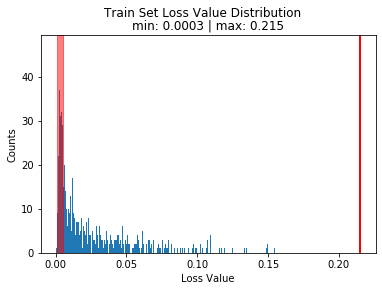

In [59]:
train_min, train_max, train_top = loss_hist(ref_train_losses, checkpoint_label, test=False)

### Get a set of images that are in the high-loss and low-loss regions of the test and train distributions

#### Low-High Loss Images for Test Set

In [60]:
loss_peak_test = []; loss_peak_reco = []
high_loss_test = []; high_loss_reco = []

In [61]:
for idx, image in enumerate(test_loader):
    
    # Flatten image into a vector -- if mlp
    if 'mlp' in exp_path:
        image = image.view(loader_kwargs['batch_size'], -1).to(device)
    else:
        image = image.to(device)
    
    # Forward pass
    output = model(image)

    # Get the loss value for the batch
    loss = loss_fn(output, image)

    # Grab samples that are within the limits given by the histogram
    if loss > test_min and loss < test_max:
        loss_peak_test.append(image.view(-1, im_dim, im_dim).detach().cpu().numpy())
        loss_peak_reco.append(output.view(-1, im_dim, im_dim).detach().cpu().numpy())
    
    if loss >= min(test_top) and loss <= max(test_top):
        high_loss_test.append(image.view(-1, im_dim, im_dim).detach().cpu().numpy())
        high_loss_reco.append(output.view(-1, im_dim, im_dim).detach().cpu().numpy())

#### Plot Sample of images from loss peak

In [63]:
limit = 16

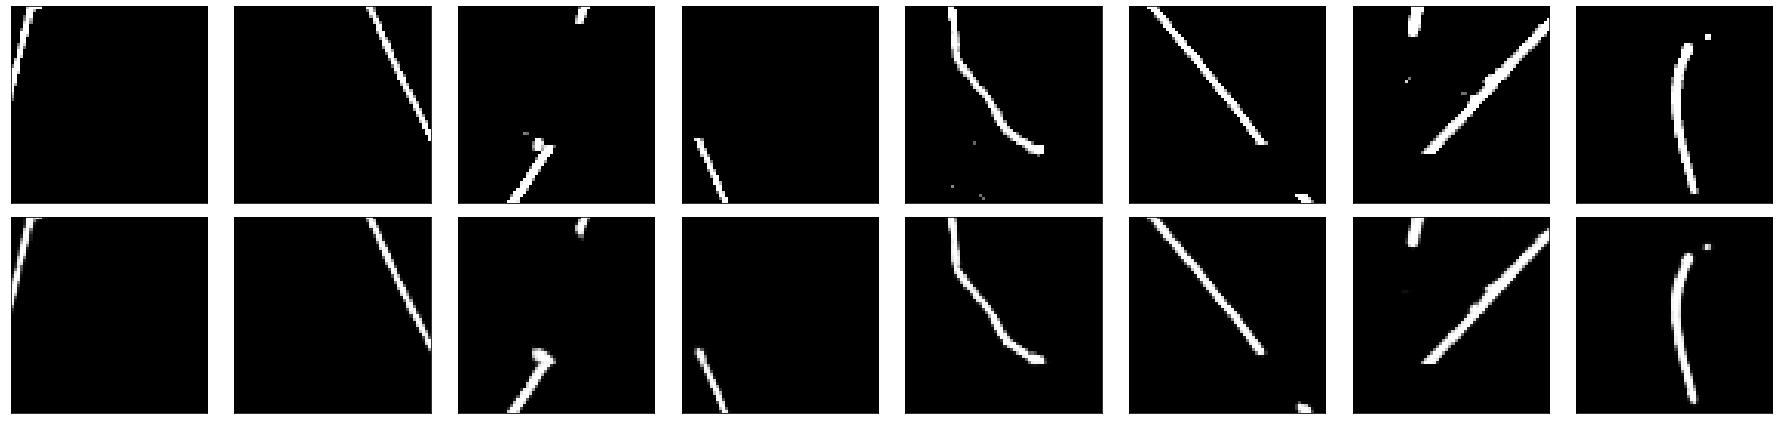

In [62]:
# Setup figure
fig, axes = plt.subplots(nrows = 2, ncols = limit//2, sharex=True, sharey=True, figsize=(25,6))

# Set title
if 'mlp' in exp_path:
    m_label = 'AE'
else:
    m_label = 'Conv_AE'

# Generate plot
for images, row in zip([loss_peak_test[0:limit//2], loss_peak_reco[0:limit//2]], axes):
    for img, ax in zip(images, row):
        img = np.reshape(img, (im_dim, im_dim))
        ax.imshow(img, cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.tick_params(axis='x', colors='#443941')
        ax.tick_params(axis='y', colors='#443941')

fig.tight_layout()

# Save figure
save_file = "{}_{}_{}.png".format('test-loss-peak', im_dim, code[0]*code[1]*code[2])
plt.savefig(save_file, dpi=300)

#### Plot the highest loss test image(s)

In [64]:
print(len(high_loss_test), len(high_loss_reco))

1 1


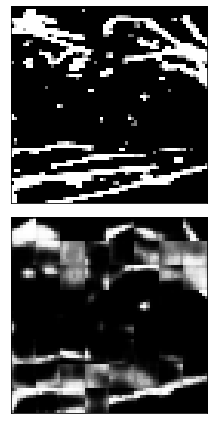

In [65]:
# Setup figure
fig, axes = plt.subplots(nrows = 2, ncols = 1, 
                         sharex=True, sharey=True, figsize=(25,6))

# Set title
if 'mlp' in exp_path:
    m_label = 'AE'
else:
    m_label = 'Conv_AE'

img = np.reshape(high_loss_test[0], (im_dim, im_dim))
axes[0].imshow(img, cmap='gray')
axes[0].get_xaxis().set_visible(False)
axes[0].get_yaxis().set_visible(False)
axes[0].tick_params(axis='x', colors='#443941')
axes[0].tick_params(axis='y', colors='#443941')

img = np.reshape(high_loss_reco[0], (im_dim, im_dim))
axes[1].imshow(img, cmap='gray')
axes[1].get_xaxis().set_visible(False)
axes[1].get_yaxis().set_visible(False)
axes[1].tick_params(axis='x', colors='#443941')
axes[1].tick_params(axis='y', colors='#443941')

fig.tight_layout()

# Save figure
save_file = "{}_{}_{}.png".format('test-highest-losses', im_dim, code[0]*code[1]*code[2])
plt.savefig(save_file, dpi=300)

#### Low-High Loss Images for Train Set

In [67]:
loss_peak_train = []; loss_peak_reco = []
high_loss_train = []; high_loss_reco = []

In [68]:
for idx, image in enumerate(train_loader):
    
    # Flatten image into a vector -- if mlp
    if 'mlp' in exp_path:
        image = image.view(loader_kwargs['batch_size'], -1).to(device)
    else:
        image = image.to(device)
    
    # Forward pass
    output = model(image)

    # Get the loss value for the batch
    loss = loss_fn(output, image)

    # Grab samples that are within the limits given by the histogram
    if loss > train_min and loss < train_max:
        loss_peak_train.append(image.view(-1, im_dim, im_dim).detach().cpu().numpy())
        loss_peak_reco.append(output.view(-1, im_dim, im_dim).detach().cpu().numpy())
    
    if loss >= min(train_top) and loss <= max(train_top):
        high_loss_train.append(image.view(-1, im_dim, im_dim).detach().cpu().numpy())
        high_loss_reco.append(output.view(-1, im_dim, im_dim).detach().cpu().numpy())

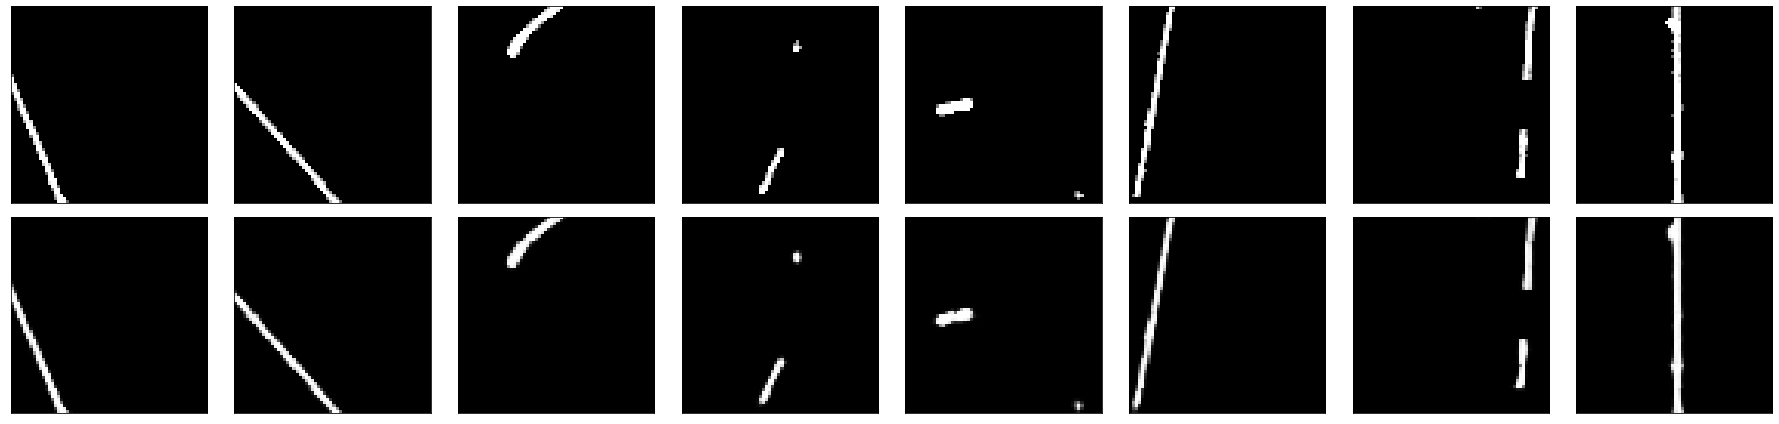

In [69]:
# Setup figure
fig, axes = plt.subplots(nrows = 2, ncols = limit//2, sharex=True, sharey=True, figsize=(25,6))

# Set title
if 'mlp' in exp_path:
    m_label = 'AE'
else:
    m_label = 'Conv_AE'

# Generate plot
for images, row in zip([loss_peak_train[0:limit//2], loss_peak_reco[0:limit//2]], axes):
    for img, ax in zip(images, row):
        img = np.reshape(img, (im_dim, im_dim))
        ax.imshow(img, cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.tick_params(axis='x', colors='#443941')
        ax.tick_params(axis='y', colors='#443941')

fig.tight_layout()

# Save figure
save_file = "{}_{}_{}.png".format('train-loss-peak', im_dim, code[0]*code[1]*code[2])
plt.savefig(save_file, dpi=300)

In [71]:
print(len(high_loss_train), len(high_loss_reco))

1 1


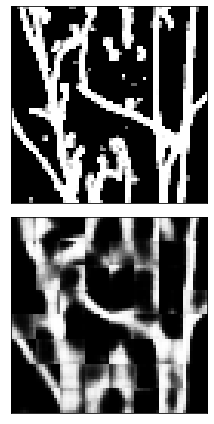

In [73]:
# Setup figure
fig, axes = plt.subplots(nrows = 2, ncols = 1, 
                         sharex=True, sharey=True, figsize=(25,6))

# Set title
if 'mlp' in exp_path:
    m_label = 'AE'
else:
    m_label = 'Conv_AE'

img = np.reshape(high_loss_train[0], (im_dim, im_dim))
axes[0].imshow(img, cmap='gray')
axes[0].get_xaxis().set_visible(False)
axes[0].get_yaxis().set_visible(False)
axes[0].tick_params(axis='x', colors='#443941')
axes[0].tick_params(axis='y', colors='#443941')

img = np.reshape(high_loss_reco[0], (im_dim, im_dim))
axes[1].imshow(img, cmap='gray')
axes[1].get_xaxis().set_visible(False)
axes[1].get_yaxis().set_visible(False)
axes[1].tick_params(axis='x', colors='#443941')
axes[1].tick_params(axis='y', colors='#443941')

fig.tight_layout()

# Save figure
save_file = "{}_{}_{}.png".format('train-highest-losses', im_dim, code[0]*code[1]*code[2])
plt.savefig(save_file, dpi=300)

### Save Evaluation Results to exp. folder

In [ ]:
eval_file = exp_path + "checkpoint_evaluation.csv"

In [ ]:
mean_deltas = []
std_deltas = []
for i in range(len(test_means)):
    mean_deltas.append( abs(test_means[i] - train_means[i]))
    std_deltas.append( abs(test_stds[i] - train_stds[i]))

In [ ]:
results = {'Test_Mean'      : test_means, 
           'Test_StdDev'    : test_stds, 
           'Train_Mean'     : train_means, 
           'Train_StdDev'   : train_stds,
           'Mean_Deltas'    : mean_deltas,
           'StdDev_Deltas' : std_deltas}

In [ ]:
results = pd.DataFrame(results, index = checkpoints)

In [ ]:
results

In [ ]:
results.to_csv(eval_file, sep=',')

In [ ]:
results.to_csv('checkpoint_eval.csv', sep=',')

In [ ]:
html = results.to_html()